# Predicting stock prices with Machine Learning: which method should you use?

## Project overview
The ability to predict movement of stock prices has been the Holy Grail for investors around the world.  In this project, we explore the topic of predicting the movement of stock prices using supervised learning, as well as more sophisticated deep learning methods.

We will discuss in detail steps taken to obtain and visulise historical data, background of each learning method used, and evaluation of the performance of each model against 8 heavily traded stocks in Hong Kong and US stock exchanges.  The 4 methods we will explore in here are SVM, Random Forrest, XGBoost, and Deep Learning with LSTM and CNN.


## Problem Statement
We seek to explore the use of machine learning for the following two problems, with the first being a simplified version of the second:
1. Can we used to classify whether a particular stock price would increase or decrease on a particular day, given observations of several preceding days' trading conditions?
2. Can we make use of Classical ML and more sophisticated Deep Learning techniques to predict the closing price (and therefore profit) of the next trading day?


## Approach

The following outlines the approach taken to address our problem statement.

1. Extract and Explore data:
    - We use data from Yahoo Finance, where we extract daily trading data from the past 10 years, including: how many stocks were traded (Volume) and closing price adjusted for stock splits (Adjusted Close)
    
    
2. Feature engineering
    - We engineer new features from our trading dataset to aid with model training, including rolling means, rolling stdev, rolling upper/lower bounds of prices.


3. Data Preparation
    - We prepare our data including splitting of training and testing sets


4. Modelling & Evaluation
    - Classification of rise / fall in an unseen day
    - Regression and Deep Learning models for price change in an unseen day
    
    
5. Conclusion

    
    
## Metrics

The performance of model will be judged by its ability to predict actual stock price.

For Problem Statement 1, we will assess the model by the accuracy with which it can classify a rise or fall in stock price on an unseen trading day, as measured by % of correctly classified days.

For Problem Statement 2, we will assess the model by the accuracy with which it can predict the actual profit from holding a stock for an unseen trading day, as measured by mean-squared-error.

## 1. Extract & Explore Data

In [681]:
import yfinance as yf
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import datetime
from tqdm import tqdm
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # 2 = INFO and WARNING messages are not printed

In [519]:
symbols = (['0005.HK', '0700.HK', '1398.HK', '1299.HK', 'AAPL', 'TSLA', 'MSFT', 'AMZN'])
start_date = '2000-01-01'
end_date = '2021-08-13'

# downloading data from Yahoo Finance
df = yf.download(symbols, start_date, end_date)

[*********************100%***********************]  8 of 8 completed


In [103]:
df.head()

Adj Close                                                         \
              0005.HK AAL      AAPL ACN     AMZN          F GOOGL       MSFT   
Date                                                                           
1999-12-31        NaN NaN  0.788183 NaN  76.1250  15.407578   NaN  36.991508   
2000-01-03  56.091545 NaN  0.858137 NaN  89.3750  15.136635   NaN  36.932102   
2000-01-04  55.052814 NaN  0.785788 NaN  81.9375  14.630879   NaN  35.684532   
2000-01-05  52.196320 NaN  0.797286 NaN  69.7500  14.685060   NaN  36.060772   
2000-01-06  50.378532 NaN  0.728291 NaN  65.5625  14.703121   NaN  34.852810   

                            ...      Volume                                   \
                  SPY TSLA  ...     0005.HK AAL         AAPL ACN        AMZN   
Date                        ...                                                
1999-12-31  98.470436  NaN  ...         NaN NaN  163811200.0 NaN   7270700.0   
2000-01-03  97.506668  NaN  ...   3908164.0 NaN  535796800.0 NaN  16117600.0   
2000-01-04  93.693573  NaN  ...   6895378.0 NaN  512377600.0 NaN  17487400.0   
2000-01-05  93.861176  NaN  ...  14657098.0 NaN  778321600.0 NaN  38457400.0   
2000-01-06  92.352676  NaN  ...  10632084.0 NaN  767972800.0 NaN  18752000.0   

                                                          
                    F GOOGL        MSFT         SPY TSLA  
Date                                                      
1999-12-31  1206272.0   NaN  12517600.0   3172700.0  NaN  
2000-01-03  4056814.0   NaN  53228400.0   8164300.0  NaN  
2000-01-04  7322428.0   NaN  54119000.0   8089800.0  NaN  
2000-01-05  5038354.0   NaN  64059600.0  12177900.0  NaN  
2000-01-06  4545037.0   NaN  54976600.0   6227200.0  NaN  

[5 rows x 60 columns]

In [45]:
df[['Adj Close']].head()

Adj Close                                                         \
              0005.HK AAL      AAPL ACN     AMZN          F GOOGL       MSFT   
Date                                                                           
1999-12-31        NaN NaN  0.788183 NaN  76.1250  15.407578   NaN  36.991508   
2000-01-03  56.091545 NaN  0.858137 NaN  89.3750  15.136635   NaN  36.932102   
2000-01-04  55.052814 NaN  0.785788 NaN  81.9375  14.630879   NaN  35.684532   
2000-01-05  52.196320 NaN  0.797286 NaN  69.7500  14.685060   NaN  36.060772   
2000-01-06  50.378532 NaN  0.728291 NaN  65.5625  14.703121   NaN  34.852810   

                            
                  SPY TSLA  
Date                        
1999-12-31  98.470436  NaN  
2000-01-03  97.506668  NaN  
2000-01-04  93.693573  NaN  
2000-01-05  93.861176  NaN  
2000-01-06  92.352676  NaN

In [520]:
# Function to plot stock price
def plot_data(df, symbols, normalise=False, title='Stock prices', ylabel='Price', y=0 , step=100, ax=None,
              start_date = '2000-01-01', end_date = '2020-10-20'):
    '''Plot stock prices
    INPUT:
    df - Dataframe
    title - title
    ylabel - label of y axis
    y - horizontal line, integer
    step - xticks step, integer
    OUTPUT: plot'''
    
    df1 = df[start_date:end_date]
    if normalise:
        df1 = df1/df1.iloc[0,:]    
    ax = df1.plot(title=title, figsize=(16,8), ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.axhline(y=y, color='black')
    ax.legend(symbols, loc='upper left')
    try:
        plt.yticks(np.arange(0, df1.max().max()+step, step=step))
    except:
        pass
    plt.show()

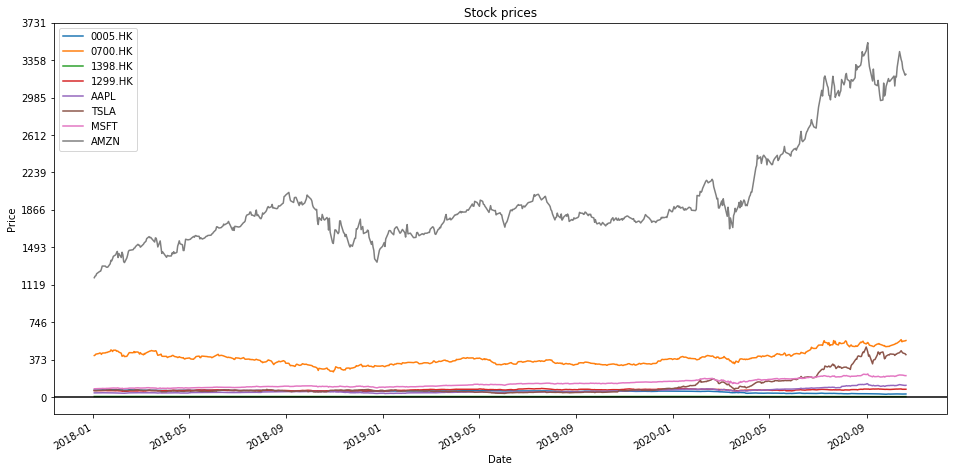

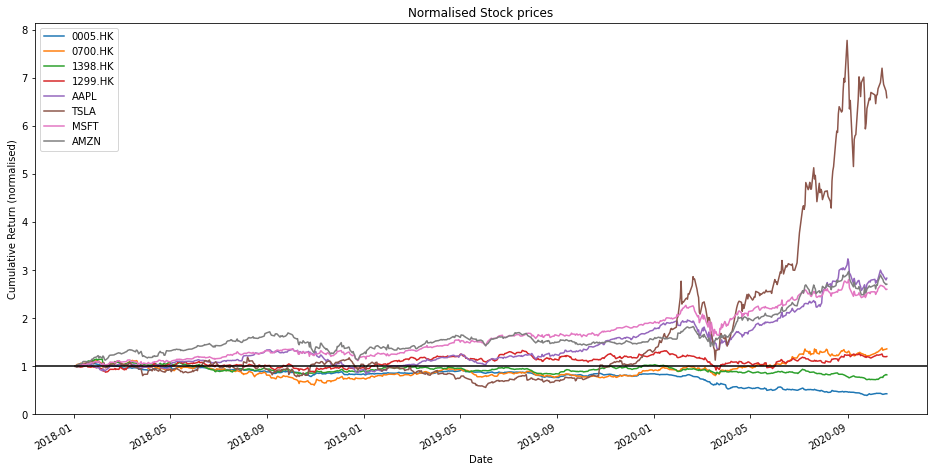

In [526]:
# Plot development of adj close stock prices for chosen companies

start_date = '2018-01-01'
end_date = '2020-10-20'
dfDrop = df.dropna()
plot_data(dfDrop['Adj Close'][symbols][start_date:end_date], symbols, title='Stock prices', ylabel='Price', y=0 , step=df['Adj Close'].max().max()/10)
plot_data(dfDrop['Adj Close'][symbols][start_date:end_date], symbols, normalise = True, title='Normalised Stock prices', ylabel='Cumulative Return (normalised)', y=1 , step=1)

## 2. Feature Engineering
In this section, we engineer features which we will later use to train our models, starting with rolling statistics for prices, and daily profits.  We also visualise these as part of our exploratory analysis.

In [129]:
# We backfill and forwardfill missing values in case any 
dfFilled = df.fillna(method='bfill')

# calculate & plot rolling stats
def rolling_stats_plot(rolling_df, rolling_symbol, window = 15, price_type = 'Adj Close'): 
    values = rolling_df[(price_type, rolling_symbol)]
    rolling_mean = rolling_df[(price_type, rolling_symbol)].rolling(window=window).mean()
    rolling_std = rolling_df[(price_type, rolling_symbol)].rolling(window=window).std()
    upper_band = rolling_mean + rolling_std*2
    lower_band = rolling_mean - rolling_std*2

    # plot parameter
    ax = rolling_mean.plot(title='Rolling mean of {} of {}'.format(price_type,rolling_symbol), figsize=(16,8), \
                           label='Rolling mean of {} days'.format(window))
    plt.plot(upper_band, label='Upper band of 2 stdev')
    plt.plot(lower_band, label='Lower band of 2 stdev')
    plt.plot(values, label='Stock Values')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc='upper left')
    plt.show()
    
    return ax

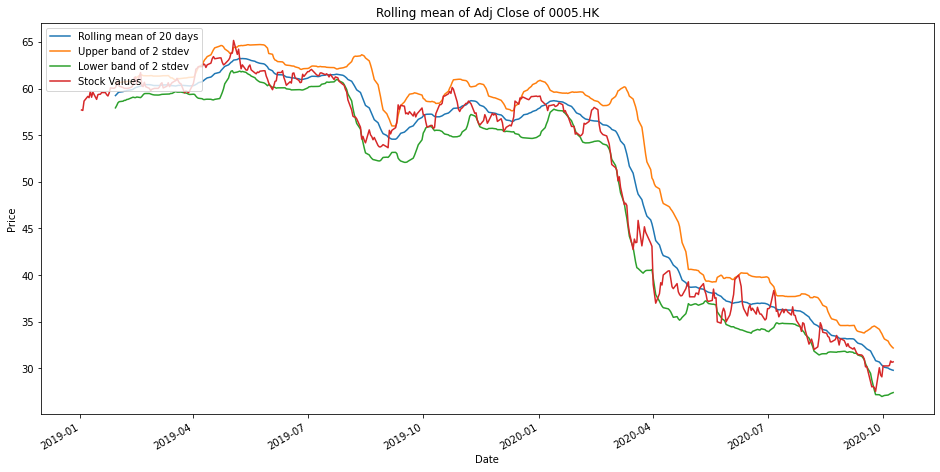

In [527]:
rolling_symbol = '0005.HK'
rolling_stats_plot(dfFilled['2019-01-01':'2020-10-10'], rolling_symbol, window = 20);

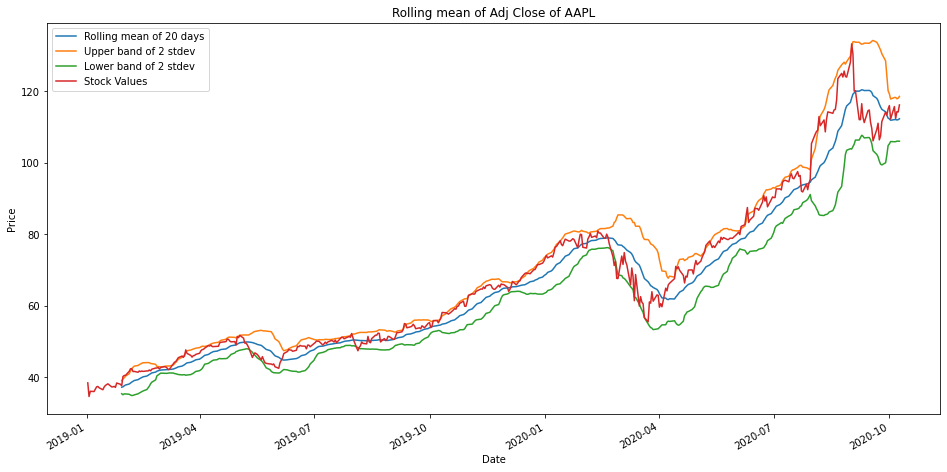

In [528]:
rolling_symbol = 'AAPL'
rolling_stats_plot(dfFilled['2019-01-01':'2020-10-10'], rolling_symbol, window = 20);

In [529]:
# Calculate daily returns - these would be what we seek to predict in later sections
return_df = df['2019-01-01':'2021-10-10']
return_symbol = 'AAPL'

def plot_daily_returns(return_df, return_symbol):
    daily_returns = (return_df[('Adj Close', return_symbol)][1:]/return_df[('Adj Close', return_symbol)][:-1].values)-1
    ax = daily_returns.plot(title='Daily return of {}'.format(return_symbol,rolling_symbol), figsize=(16,8), \
                               label='Daily return of {}'.format(rolling_symbol))
    return ax

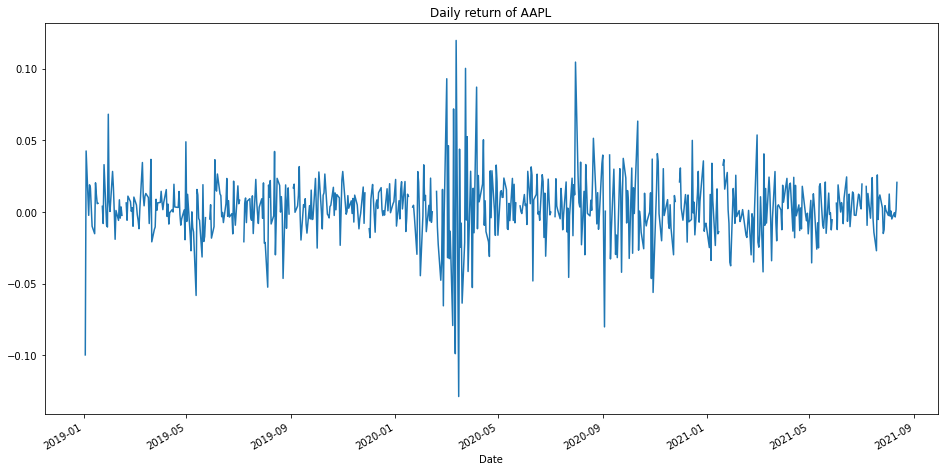

In [530]:
plot_daily_returns(return_df, 'AAPL');

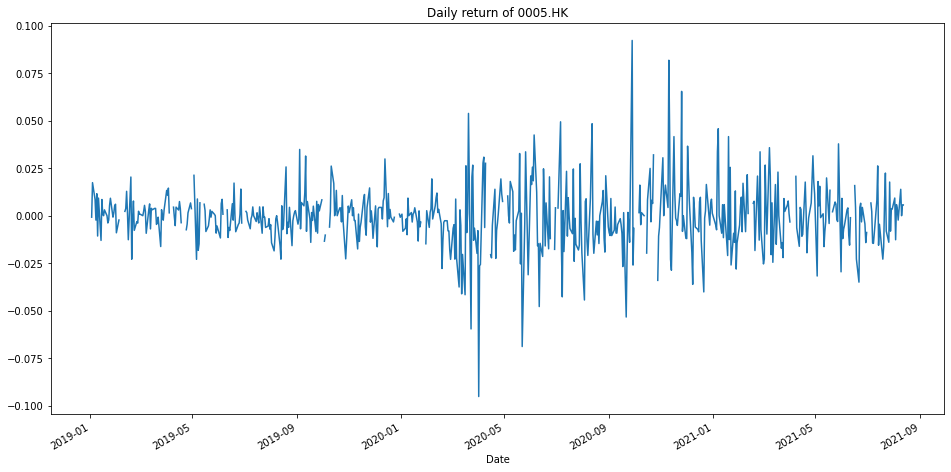

In [531]:
plot_daily_returns(return_df, '0005.HK');

## 3. Data Preparation
In this section, we create a Dataframe with engineered features and cleansed data, ready for modelling

In [735]:

def create_ml_df(df, symbol):
    '''This function calculates features used for machine learning
    INPUT:
    df - DataFrame with stock data from yahoo finance
    symbol - symbol of stock
    OUTPUT: machine learning '''
    
    ml_df = pd.DataFrame (data = df.iloc[:, df.columns.get_level_values(1)==symbol].values,
                          index = df.iloc[:, df.columns.get_level_values(1)==symbol].index,
                          columns = df.iloc[:, df.columns.get_level_values(1)==symbol].columns.get_level_values(0))
    ml_df.dropna(inplace=True)
    
    # Add Rolling mean and Rollind std 20 for Adj Close
    ml_df['Rolling mean Adj Close 20'] = ml_df['Adj Close'].rolling(window=20).mean()
    ml_df['Rolling std Adj Close 20'] = ml_df['Adj Close'].rolling(window=20).std()
    ml_df['Low 14'] = ml_df['Adj Close'].rolling(window=14).min()
    ml_df['High 14'] = ml_df['Adj Close'].rolling(window=14).max()
    
    # Williams %R - is a technical analysis oscillator showing the current closing price in relation to the high and low of the past N days
    ml_df['Williams %R'] = (ml_df['High 14']-ml_df['Adj Close'])/(ml_df['High 14']-ml_df['Low 14'])*100
    ml_df['Returns'] = np.log(ml_df['Adj Close'] / ml_df['Adj Close'].shift())
    
    # create windowed dataset showing the past 5 days for each observed price
    ml_df['Adj Close prior 1 day'] = ml_df['Adj Close'].shift(1)
    ml_df['Adj Close prior 2 day'] = ml_df['Adj Close'].shift(2)
    ml_df['Adj Close prior 3 day'] = ml_df['Adj Close'].shift(3)
    ml_df['Adj Close prior 4 day'] = ml_df['Adj Close'].shift(4)
    ml_df['Adj Close prior 5 day'] = ml_df['Adj Close'].shift(5)
    ml_df['Volume prior 1 day'] = ml_df['Volume'].shift(1)
    ml_df['Volume prior 2 day'] = ml_df['Volume'].shift(2)
    ml_df['Volume prior 3 day'] = ml_df['Volume'].shift(3)
    ml_df['Volume prior 4 day'] = ml_df['Volume'].shift(4)
    ml_df['Volume prior 5 day'] = ml_df['Volume'].shift(5)
    ml_df['Returns prior 1 day'] = ml_df['Returns'].shift(1)
    ml_df['Returns prior 2 day'] = ml_df['Returns'].shift(2)
    ml_df['Returns prior 3 day'] = ml_df['Returns'].shift(3)
    ml_df['Returns prior 4 day'] = ml_df['Returns'].shift(4)
    ml_df['Returns prior 5 day'] = ml_df['Returns'].shift(5)
    ml_df.dropna(inplace=True)
    
    return ml_df

ml_df = create_ml_df(df, '0005.HK')
ml_df.sample(3)

,Adj Close,Close,High,Low,Open,Volume,Rolling mean Adj Close 20,Rolling std Adj Close 20,Low 14,High 14,...,Volume prior 1 day,Volume prior 2 day,Volume prior 3 day,Volume prior 4 day,Volume prior 5 day,Returns prior 1 day,Returns prior 2 day,Returns prior 3 day,Returns prior 4 day,Returns prior 5 day
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-11,38.609486,62.700001,63.799999,62.500000,63.200001,23238268.0,37.852069,1.249356,35.007160,39.102104,...,22572725.0,27697128.0,29335630.0,29013910.0,29682170.0,-0.000811,0.038864,0.042193,-0.025186,-0.043631
2009-02-11,36.016933,59.950001,60.900002,59.650002,60.299999,21331187.0,37.311624,3.111546,33.043068,37.849331,...,24798645.0,22518085.0,25110879.0,21244506.0,13435453.0,0.007968,0.006420,0.046137,0.002532,0.019634
2004-07-14,62.206715,115.000000,116.000000,114.500000,115.000000,15121703.0,62.652986,0.498525,62.206715,63.559059,...,10617872.0,6860691.0,5971807.0,17394040.0,13803580.0,-0.004319,0.004319,0.004339,-0.008658,0.000000


## 4. Modelling & Evaluation
In this section, we finally get to the most exciting part of the show - the modelling and the machine learning.  We will be using 4 machine learning methods: SVM, Random Forrest, XGBoost and finally Deep Learning with LSTM and CNN.

### 4.1 Classification via SVM

In [546]:
# function to train SVC model
def svc_train(ml_df, start_train, end_train, start_test, end_test, features):
    
    df_train = ml_df[start_train: end_train]
    X_train, y_train = df_train[features], np.sign(df_train['Returns'])

    df_test = ml_df[start_test: end_test]
    X_test, y_test = df_test[features], np.sign(df_test['Returns'])

    model = SVC(gamma='scale')
    model.fit(X_train, np.sign(y_train))
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)

    print('Accuracy of Prediction:', format(model.score(X_test, y_test)*100, '.2f'), '%') 
    return y_pred, y_test, accuracy

In [640]:
features = ['Adj Close', 'Volume', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20',\
            'Adj Close prior 1 day', 'Adj Close prior 2 day', 'Adj Close prior 3 day', \
           'Volume prior 1 day']
y_pred_list = []
y_test_list = []
accuracy_list = []

for stock in symbols:
    ml_df = create_ml_df(df, stock)
    print(stock)
    y_pred, y_test, accuracy = svc_train(ml_df, "2018-01-01", "2021-07-15", "2021-07-16", "2021-08-13", features)
    y_pred_list.append(y_pred)
    y_test_list.append(y_test)
    accuracy_list.append(accuracy)

0005.HK
Accuracy of Prediction: 70.00 %
0700.HK
Accuracy of Prediction: 55.00 %
1398.HK
Accuracy of Prediction: 65.00 %
1299.HK
Accuracy of Prediction: 55.00 %
AAPL
Accuracy of Prediction: 50.00 %
TSLA
Accuracy of Prediction: 70.00 %
MSFT
Accuracy of Prediction: 45.00 %
AMZN
Accuracy of Prediction: 55.00 %


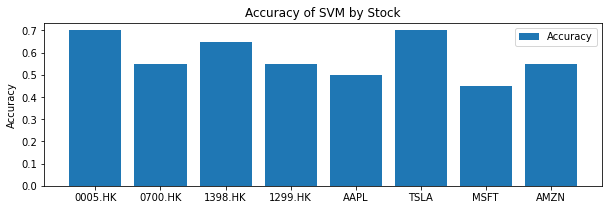

In [641]:
# Plot accuracy of our SVM model
def plot_accuracy(accuracy_list, symbols, title):
    x = np.arange(len(symbols))  # the label locations
    fig, ax = plt.subplots(figsize=(10,3))
    bars = ax.bar(x, accuracy_list, label = "Accuracy");
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(symbols)
    ax.legend()
    return ax

plot_accuracy(accuracy_list, symbols, 'Accuracy of SVM by Stock');

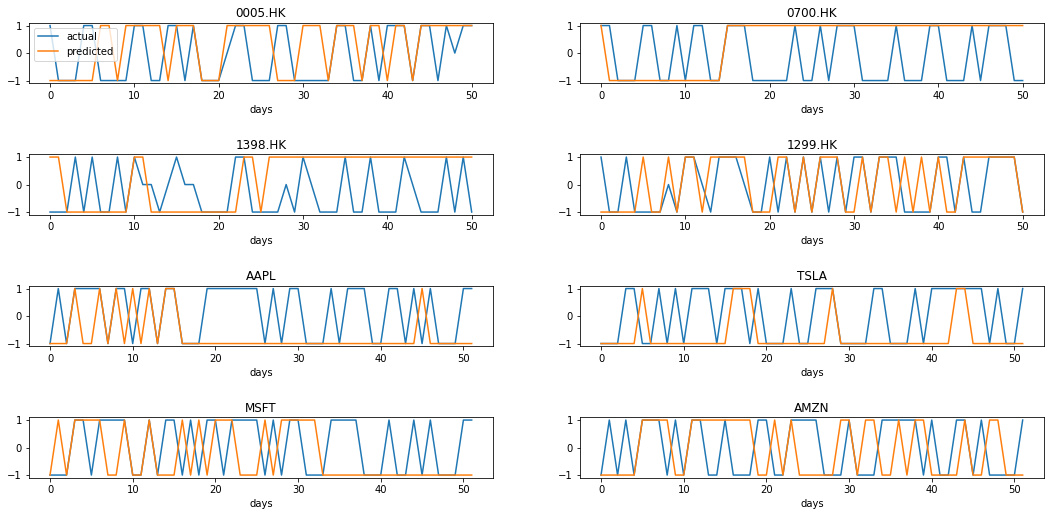

In [732]:
# Plot pred vs. actual
def plot_pred_vs_actual(y_test_list, y_pred_list, symbols):
    ncols = 2 # number of columns
    nrows = int(math.ceil(len(symbols)/2))

    fig, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize=(16,8))
    fig.tight_layout(pad=5.0)
    
    for i in range(len(symbols)):
        ax = plt.subplot(nrows, ncols, i+1)
        try: # the following would run fine for scikit-learn routines (not for TF)
            y_test_plot = y_test_list[i].values
            plt.plot(y_test_plot,  label="actual")
            plt.plot(y_pred_list[i], label="predicted")
        except:
            # this is a TF tensor, convert inputs to numpy first
            y_test_plot = y_test_list_dl[i].numpy()[0]
            plt.plot(y_test_plot,  label="actual")
            plt.plot(y_pred_list[i][0], label="predicted")
        plt.xlabel("days")
        plt.title(symbols[i])
        if i == 0:
            plt.legend(loc = "upper left")
    
    return fig

plot_pred_vs_actual(y_test_list, y_pred_list, symbols);

As can be seen, the accuracy of classification for the 8 stocks is between 50% to 70%; which means they are just slightly above random chance of 50%, meaning our model performed better than simple guessing.  In order to improve our performance, we will use an "ensemble method", namely Random Forrest.

### 4.2 Classification via Random Forrest

In [742]:
# classification of rise / fall next day

def mod_rfc(ml_df, start_train, end_train, start_test, end_test, features, print_acc = True):
    df_train = ml_df[start_train: end_train]
    X_train, y_train = df_train[features], np.sign(df_train['Returns'])

    df_test = ml_df[start_test: end_test]
    X_test, y_test = df_test[features], np.sign(df_test['Returns'])
    
    model = RandomForestClassifier(max_depth=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    if print_acc==True:
        print('Accuracy of Prediction for training dates of ', start_train, 'to', end_train, '; and testing dates of ', start_test, 'to',
              end_test, ' is:\n', format(model.score(X_test, y_test)*100, '.2f'), '%')
    return y_pred, y_test, accuracy

In [743]:
features = ['Adj Close', 'Volume', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20',\
            'Adj Close prior 1 day', 'Adj Close prior 2 day', 'Adj Close prior 3 day', \
           'Volume prior 1 day']
y_pred_list_rf = []
y_test_list_rf = []
accuracy_list_rf = []
for stock in symbols:
    ml_df = create_ml_df(df, stock)
    print(stock)
    y_pred, y_test, accuracy = mod_rfc(ml_df, "2018-01-01", "2021-07-15", "2021-07-16", "2021-08-13", features)
    y_pred_list_rf.append(y_pred)
    y_test_list_rf.append(y_test)
    accuracy_list_rf.append(accuracy)


0005.HK
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 70.00 %
0700.HK
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 40.00 %
1398.HK
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 45.00 %
1299.HK
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 65.00 %
AAPL
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 55.00 %
TSLA
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 60.00 %
MSFT
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 70.00 %
AMZN
Accuracy o

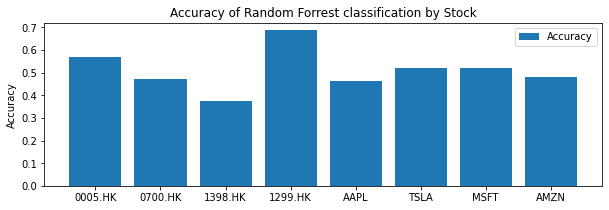

In [648]:
plot_accuracy(accuracy_list_rf, symbols, 'Accuracy of Random Forrest classification by Stock');

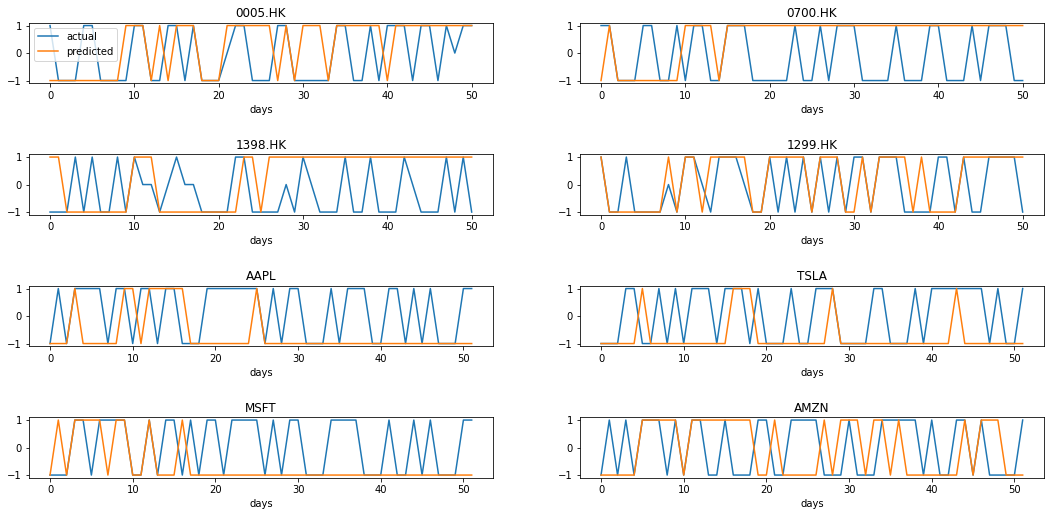

In [656]:
plot_pred_vs_actual(y_test_list_rf, y_pred_list_rf, symbols);

As can be seen, the model performed similarly to the SVM, with the notable exception of AAPL, where the model achieved an accuracy poorer than guessing (45%).

In light of this, we attempt to include additional features during the training process.

In [747]:
features = ['Adj Close', 'Volume', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20',\
            'Adj Close prior 1 day', 'Adj Close prior 2 day', 'Adj Close prior 3 day', \
             'Adj Close prior 4 day', 'Adj Close prior 5 day', \
           'Volume prior 1 day']
y_pred_list_rf = []
y_test_list_rf = []
accuracy_list_rf = []
for stock in symbols:
    ml_df = create_ml_df(df, stock)
    print(stock)
    y_pred, y_test, accuracy = mod_rfc(ml_df, "2018-01-01", "2021-07-15", "2021-07-16", "2021-08-13", features)
    y_pred_list_rf.append(y_pred)
    y_test_list_rf.append(y_test)
    accuracy_list_rf.append(accuracy)

0005.HK
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 55.00 %
0700.HK
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 40.00 %
1398.HK
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 50.00 %
1299.HK
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 65.00 %
AAPL
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 50.00 %
TSLA
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 70.00 %
MSFT
Accuracy of Prediction for training dates of  2018-01-01 to 2021-07-15 ; and testing dates of  2021-07-16 to 2021-08-13  is:
 60.00 %
AMZN
Accuracy o

Unfortunately, this does not yield better results and suggests that more features actually served to encourage overfitting of the model.

### 4.3 Price prediction via XGBoost
In this section, we move beyond just classifying whether a trading day would be up or down, and instead predict the actual profit that would be made on a trading day.  Due to the more compelx nature of this exercise, we increase the breadth of the training set to include historical data dating back to 2010.

In [744]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score

def model_xgb(ml_df, start_train, end_train, start_test, end_test, features, print_acc = True):
    df_train = ml_df[start_train: end_train]
    #     X_train, y_train = df_train[features], np.sign(df_train['Returns'])
    X_train, y_train = df_train[features], (df_train['Returns'])
    
    df_test = ml_df[start_test: end_test]
    #     X_test, y_test = df_test[features], np.sign(df_test['Returns'])
    X_test, y_test = df_test[features], (df_test['Returns'])
    
    model = XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)

    if print_acc==True:
        #         print('Accuracy of Prediction for : ', start_train, ' - ', end_train, ' - ', start_test, ' - ',
        #               end_test, '\n', format(model.score(X_test, y_test)*100, '.2f'), '%')
        
        print('Accuracy of Prediction for training dates of ', start_train, 'to', end_train, '; and testing dates of ', start_test, 'to',
              end_test, ' is:\n', format(model.score(X_test, y_test)*100, '.2f'), '%')
    return y_pred, y_test, accuracy, model

In [745]:
features = ['Adj Close', 'Volume', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20',\
            'Adj Close prior 1 day', 'Adj Close prior 2 day', 'Adj Close prior 3 day', \
           'Volume prior 1 day', 'Volume prior 2 day',  'Volume prior 3 day', \
           'Returns prior 1 day', 'Returns prior 2 day', 'Returns prior 3 day']

y_pred_list_xgb = []
y_test_list_xgb = []
accuracy_list_xgb = []

# for stock in symbols:
for stock in symbols:
    ml_df = create_ml_df(df, stock)
    print(stock)
    y_pred, y_test, accuracy, model = model_xgb(ml_df, "2010-01-01", "2021-07-30", "2021-08-02", "2021-08-13", features)
    y_pred_list_xgb.append(y_pred)
    y_test_list_xgb.append(y_test)
    accuracy_list_xgb.append(accuracy)

0005.HK
Accuracy of Prediction for training dates of  2010-01-01 to 2021-07-30 ; and testing dates of  2021-08-02 to 2021-08-13  is:
 82.71 %
0700.HK
Accuracy of Prediction for training dates of  2010-01-01 to 2021-07-30 ; and testing dates of  2021-08-02 to 2021-08-13  is:
 36.94 %
1398.HK
Accuracy of Prediction for training dates of  2010-01-01 to 2021-07-30 ; and testing dates of  2021-08-02 to 2021-08-13  is:
 71.42 %
1299.HK
Accuracy of Prediction for training dates of  2010-01-01 to 2021-07-30 ; and testing dates of  2021-08-02 to 2021-08-13  is:
 28.74 %
AAPL
Accuracy of Prediction for training dates of  2010-01-01 to 2021-07-30 ; and testing dates of  2021-08-02 to 2021-08-13  is:
 45.89 %
TSLA
Accuracy of Prediction for training dates of  2010-01-01 to 2021-07-30 ; and testing dates of  2021-08-02 to 2021-08-13  is:
 -0.08 %
MSFT
Accuracy of Prediction for training dates of  2010-01-01 to 2021-07-30 ; and testing dates of  2021-08-02 to 2021-08-13  is:
 -92.15 %
AMZN
Accuracy 

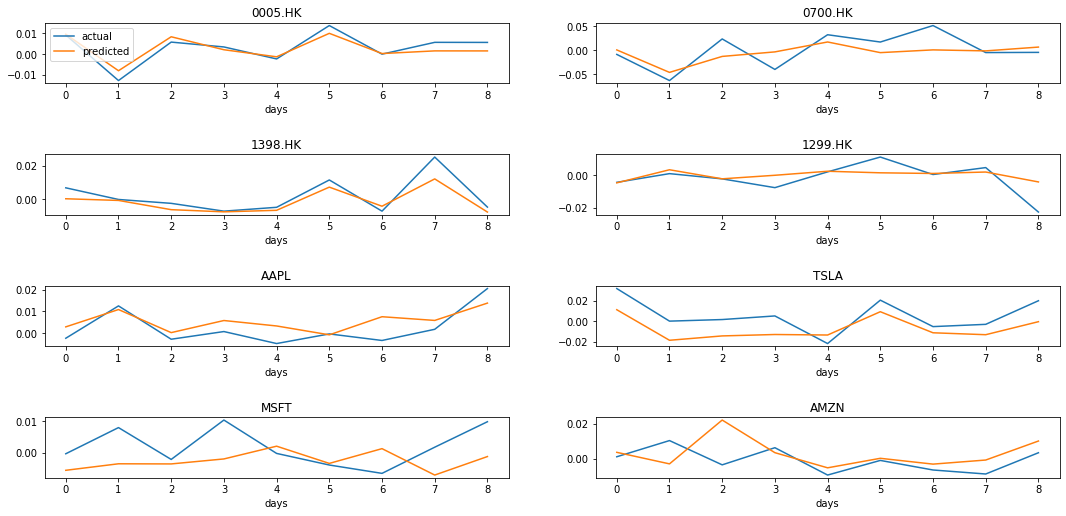

In [746]:
plot_pred_vs_actual(y_test_list_xgb, y_pred_list_xgb, symbols);

As can be seen, there is a very wide variety of behaviours from the XGBoost model depending on the individual stock.  0005.HK (HSBC Bank) performed surprisingly well, achieving an accuracy of 82% and the predicted profit trajectory very closely resembled the actual pricing.  However, the same cannot be said about AMZN (Amazon), where the sharp rise on the 2nd day of testing was completely missed.

### 4.4 Price prediction via Deep Learning
To further improve modelling performance, we now use a deep learning algorithm with LSTM and CNN to train the model.

In [714]:
# Regressor model for value change
features = ['Adj Close', 'Volume', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20',\
            'Adj Close prior 1 day', 'Adj Close prior 2 day', 'Adj Close prior 3 day', \
           'Volume prior 1 day', 'Volume prior 2 day',  'Volume prior 3 day', \
           'Returns prior 1 day', 'Returns prior 2 day', 'Returns prior 3 day']
ml_df = create_ml_df(df, 'TSLA')

import tensorflow as tf

# start_train, end_train, start_test, end_test = "2018-01-01", "2021-05-30", "2021-06-13", "2021-08-13"
def model_dl(ml_df, start_train, end_train, start_test, end_test, features, print_acc = True):
    df_train = ml_df[start_train: end_train]
    # X_train, y_train = df_train[features], np.sign(df_train['Returns'])
    X_train, y_train = df_train[features], df_train['Returns']

    df_test = ml_df[start_test: end_test]
    # X_test, y_test = df_test[features], np.sign(df_test['Returns'])
    X_test, y_test = df_test[features], df_test['Returns']

    X_train = tf.expand_dims(X_train, axis=0) # add one more dimension (for dimensionality) to feed into NN
    X_test = tf.expand_dims(X_test, axis=0) # add one more dimension (for dimensionality) to feed into NN

    y_train = tf.expand_dims(y_train, axis=0) # add one more dimension (for dimensionality) to feed into NN
    y_test = tf.expand_dims(y_test, axis=0) # add one more dimension (for dimensionality) to feed into NN

    n_steps = X_train.shape[1]
    n_features = X_train.shape[2]

    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=(n_steps, n_features) ),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1)
    ])
#     optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#     model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # model.summary()
    history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test), use_multiprocessing=True)
    y_pred = model.predict(X_test)
    accuracy = model.evaluate(X_test, y_test)[1]
    
    return y_pred, y_test, accuracy, model

In [716]:
features = ['Adj Close', 'Volume', 'Rolling mean Adj Close 20', 'Rolling std Adj Close 20',\
            'Adj Close prior 1 day', 'Adj Close prior 2 day', 'Adj Close prior 3 day', \
           'Volume prior 1 day', 'Volume prior 2 day',  'Volume prior 3 day', \
           'Returns prior 1 day', 'Returns prior 2 day', 'Returns prior 3 day']
ml_df = create_ml_df(df, 'TSLA')

y_pred_list_dl = []
y_test_list_dl = []
accuracy_list_dl = []

for stock in symbols:
    ml_df = create_ml_df(df, stock)
    print(stock)
    y_pred, y_test, accuracy, model = model_dl(ml_df, "2010-01-01", "2021-07-30", "2021-08-02", "2021-08-13", features)
    y_pred_list_dl.append(y_pred)
    y_test_list_dl.append(y_test)
    accuracy_list_dl.append(accuracy)


0005.HK
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.0468 - mae: 0.2111 - val_loss: 0.0076 - val_mae: 0.0753
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.0127 - mae: 0.1058 - val_loss: 0.0051 - val_mae: 0.0617
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.0045 - mae: 0.0586 - val_loss: 0.0030 - val_mae: 0.0486
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.0023 - mae: 0.0390 - val_loss: 0.0019 - val_mae: 0.0399
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.0013 - mae: 0.0282 - val_loss: 0.0014 - val_mae: 0.0324
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.0011 - mae: 0.0256 - val_loss: 0.0012 - val_mae: 0.0268
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 0.0013 - mae: 0.0297 - val_loss: 0.0011 - val_mae: 0.0244
Epoch 8/100
1/1 [==============================] - 2s 2s/step - loss: 0.0015 - mae: 0.0315 - val

Epoch 60/100
1/1 [==============================] - 2s 2s/step - loss: 2.4270e-04 - mae: 0.0116 - val_loss: 0.0012 - val_mae: 0.0319
Epoch 61/100
1/1 [==============================] - 2s 2s/step - loss: 2.4112e-04 - mae: 0.0115 - val_loss: 0.0011 - val_mae: 0.0316
Epoch 62/100
1/1 [==============================] - 2s 2s/step - loss: 2.3973e-04 - mae: 0.0115 - val_loss: 0.0011 - val_mae: 0.0314
Epoch 63/100
1/1 [==============================] - 2s 2s/step - loss: 2.3852e-04 - mae: 0.0115 - val_loss: 0.0011 - val_mae: 0.0312
Epoch 64/100
1/1 [==============================] - 2s 2s/step - loss: 2.3741e-04 - mae: 0.0114 - val_loss: 0.0011 - val_mae: 0.0311
Epoch 65/100
1/1 [==============================] - 2s 2s/step - loss: 2.3631e-04 - mae: 0.0114 - val_loss: 0.0011 - val_mae: 0.0310
Epoch 66/100
1/1 [==============================] - 2s 2s/step - loss: 2.3515e-04 - mae: 0.0114 - val_loss: 0.0011 - val_mae: 0.0310
Epoch 67/100
1/1 [==============================] - 2s 2s/step - loss

1/1 [==============================] - 2s 2s/step - loss: 0.0010 - mae: 0.0245 - val_loss: 0.0029 - val_mae: 0.0439
Epoch 17/100
1/1 [==============================] - 2s 2s/step - loss: 8.9316e-04 - mae: 0.0229 - val_loss: 0.0028 - val_mae: 0.0442
Epoch 18/100
1/1 [==============================] - 2s 2s/step - loss: 8.0664e-04 - mae: 0.0218 - val_loss: 0.0024 - val_mae: 0.0404
Epoch 19/100
1/1 [==============================] - 2s 2s/step - loss: 7.6958e-04 - mae: 0.0214 - val_loss: 0.0027 - val_mae: 0.0423
Epoch 20/100
1/1 [==============================] - 1s 1s/step - loss: 7.5109e-04 - mae: 0.0211 - val_loss: 0.0022 - val_mae: 0.0395
Epoch 21/100
1/1 [==============================] - 1s 1s/step - loss: 7.5357e-04 - mae: 0.0211 - val_loss: 0.0021 - val_mae: 0.0381
Epoch 22/100
1/1 [==============================] - 2s 2s/step - loss: 7.2162e-04 - mae: 0.0206 - val_loss: 0.0022 - val_mae: 0.0404
Epoch 23/100
1/1 [==============================] - 2s 2s/step - loss: 7.0603e-04 - ma

Epoch 78/100
1/1 [==============================] - 1s 1s/step - loss: 4.4063e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0297
Epoch 79/100
1/1 [==============================] - 1s 1s/step - loss: 4.3961e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0297
Epoch 80/100
1/1 [==============================] - 1s 1s/step - loss: 4.3955e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0299
Epoch 81/100
1/1 [==============================] - 1s 1s/step - loss: 4.3854e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0299
Epoch 82/100
1/1 [==============================] - 1s 1s/step - loss: 4.3666e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0292
Epoch 83/100
1/1 [==============================] - 1s 1s/step - loss: 4.3568e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0291
Epoch 84/100
1/1 [==============================] - 1s 1s/step - loss: 4.3520e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0291
Epoch 85/100
1/1 [==============================] - 1s 1s/step - loss

1/1 [==============================] - 1s 1s/step - loss: 3.4459e-04 - mae: 0.0142 - val_loss: 7.7560e-04 - val_mae: 0.0215
Epoch 34/100
1/1 [==============================] - 1s 1s/step - loss: 3.4501e-04 - mae: 0.0142 - val_loss: 7.7002e-04 - val_mae: 0.0216
Epoch 35/100
1/1 [==============================] - 1s 1s/step - loss: 3.3922e-04 - mae: 0.0140 - val_loss: 7.5697e-04 - val_mae: 0.0215
Epoch 36/100
1/1 [==============================] - 1s 1s/step - loss: 3.3002e-04 - mae: 0.0138 - val_loss: 7.3893e-04 - val_mae: 0.0214
Epoch 37/100
1/1 [==============================] - 1s 1s/step - loss: 3.2136e-04 - mae: 0.0136 - val_loss: 7.1906e-04 - val_mae: 0.0212
Epoch 38/100
1/1 [==============================] - 2s 2s/step - loss: 3.1610e-04 - mae: 0.0134 - val_loss: 7.0036e-04 - val_mae: 0.0210
Epoch 39/100
1/1 [==============================] - 1s 1s/step - loss: 3.1460e-04 - mae: 0.0134 - val_loss: 6.8510e-04 - val_mae: 0.0209
Epoch 40/100
1/1 [==============================] - 1s

Epoch 93/100
1/1 [==============================] - 2s 2s/step - loss: 2.6502e-04 - mae: 0.0121 - val_loss: 4.5419e-04 - val_mae: 0.0171
Epoch 94/100
1/1 [==============================] - 2s 2s/step - loss: 2.6462e-04 - mae: 0.0121 - val_loss: 4.5167e-04 - val_mae: 0.0171
Epoch 95/100
1/1 [==============================] - 2s 2s/step - loss: 2.6425e-04 - mae: 0.0121 - val_loss: 4.4963e-04 - val_mae: 0.0171
Epoch 96/100
1/1 [==============================] - 2s 2s/step - loss: 2.6387e-04 - mae: 0.0120 - val_loss: 4.4805e-04 - val_mae: 0.0171
Epoch 97/100
1/1 [==============================] - 2s 2s/step - loss: 2.6348e-04 - mae: 0.0120 - val_loss: 4.4684e-04 - val_mae: 0.0170
Epoch 98/100
1/1 [==============================] - 2s 2s/step - loss: 2.6310e-04 - mae: 0.0120 - val_loss: 4.4580e-04 - val_mae: 0.0170
Epoch 99/100
1/1 [==============================] - 2s 2s/step - loss: 2.6272e-04 - mae: 0.0120 - val_loss: 4.4478e-04 - val_mae: 0.0170
Epoch 100/100
1/1 [======================

1/1 [==============================] - 1s 1s/step - loss: 3.4593e-04 - mae: 0.0142 - val_loss: 2.9471e-04 - val_mae: 0.0131
Epoch 48/100
1/1 [==============================] - 1s 1s/step - loss: 3.4183e-04 - mae: 0.0141 - val_loss: 2.8760e-04 - val_mae: 0.0129
Epoch 49/100
1/1 [==============================] - 1s 1s/step - loss: 3.3959e-04 - mae: 0.0140 - val_loss: 2.8021e-04 - val_mae: 0.0127
Epoch 50/100
1/1 [==============================] - 1s 1s/step - loss: 3.3908e-04 - mae: 0.0140 - val_loss: 2.7569e-04 - val_mae: 0.0126
Epoch 51/100
1/1 [==============================] - 1s 1s/step - loss: 3.3855e-04 - mae: 0.0139 - val_loss: 2.7446e-04 - val_mae: 0.0126
Epoch 52/100
1/1 [==============================] - 1s 1s/step - loss: 3.3672e-04 - mae: 0.0139 - val_loss: 2.7604e-04 - val_mae: 0.0127
Epoch 53/100
1/1 [==============================] - 1s 1s/step - loss: 3.3390e-04 - mae: 0.0138 - val_loss: 2.7959e-04 - val_mae: 0.0128
Epoch 54/100
1/1 [==============================] - 1s

Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.0252 - mae: 0.1541 - val_loss: 0.0074 - val_mae: 0.0750
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.0074 - mae: 0.0777 - val_loss: 0.0083 - val_mae: 0.0781
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.0050 - mae: 0.0573 - val_loss: 0.0061 - val_mae: 0.0593
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.0031 - mae: 0.0434 - val_loss: 0.0050 - val_mae: 0.0519
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.0017 - mae: 0.0315 - val_loss: 0.0039 - val_mae: 0.0473
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 0.0026 - mae: 0.0430 - val_loss: 0.0033 - val_mae: 0.0418
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 0.0032 - mae: 0.0496 - val_loss: 0.0023 - val_mae: 0.0318
Epoch 9/100
1/1 [==============================] - 1s 1s/step - loss: 0.0028 - mae: 0.0453 - val_loss: 0

1/1 [==============================] - 1s 1s/step - loss: 3.4681e-04 - mae: 0.0133 - val_loss: 2.7904e-04 - val_mae: 0.0126
Epoch 64/100
1/1 [==============================] - 1s 1s/step - loss: 3.4828e-04 - mae: 0.0133 - val_loss: 2.6827e-04 - val_mae: 0.0125
Epoch 65/100
1/1 [==============================] - 1s 1s/step - loss: 3.4772e-04 - mae: 0.0133 - val_loss: 2.7593e-04 - val_mae: 0.0125
Epoch 66/100
1/1 [==============================] - 1s 1s/step - loss: 3.4640e-04 - mae: 0.0133 - val_loss: 2.7158e-04 - val_mae: 0.0127
Epoch 67/100
1/1 [==============================] - 1s 1s/step - loss: 3.4661e-04 - mae: 0.0133 - val_loss: 2.5346e-04 - val_mae: 0.0124
Epoch 68/100
1/1 [==============================] - 1s 1s/step - loss: 3.4491e-04 - mae: 0.0133 - val_loss: 2.3981e-04 - val_mae: 0.0118
Epoch 69/100
1/1 [==============================] - 1s 1s/step - loss: 3.4565e-04 - mae: 0.0133 - val_loss: 1.9773e-04 - val_mae: 0.0107
Epoch 70/100
1/1 [==============================] - 1s

1/1 [==============================] - 1s 1s/step - loss: 0.0014 - mae: 0.0271 - val_loss: 9.6944e-04 - val_mae: 0.0264
Epoch 19/100
1/1 [==============================] - 1s 1s/step - loss: 0.0014 - mae: 0.0269 - val_loss: 9.7543e-04 - val_mae: 0.0265
Epoch 20/100
1/1 [==============================] - 1s 1s/step - loss: 0.0014 - mae: 0.0269 - val_loss: 9.7952e-04 - val_mae: 0.0267
Epoch 21/100
1/1 [==============================] - 1s 1s/step - loss: 0.0014 - mae: 0.0268 - val_loss: 9.8080e-04 - val_mae: 0.0269
Epoch 22/100
1/1 [==============================] - 1s 1s/step - loss: 0.0014 - mae: 0.0267 - val_loss: 9.7428e-04 - val_mae: 0.0270
Epoch 23/100
1/1 [==============================] - 1s 1s/step - loss: 0.0014 - mae: 0.0265 - val_loss: 9.6105e-04 - val_mae: 0.0270
Epoch 24/100
1/1 [==============================] - 1s 1s/step - loss: 0.0014 - mae: 0.0263 - val_loss: 9.4398e-04 - val_mae: 0.0268
Epoch 25/100
1/1 [==============================] - 1s 1s/step - loss: 0.0014 - ma

Epoch 80/100
1/1 [==============================] - 1s 1s/step - loss: 0.0012 - mae: 0.0243 - val_loss: 8.7467e-04 - val_mae: 0.0251
Epoch 81/100
1/1 [==============================] - 1s 1s/step - loss: 0.0012 - mae: 0.0243 - val_loss: 8.7424e-04 - val_mae: 0.0251
Epoch 82/100
1/1 [==============================] - 1s 1s/step - loss: 0.0012 - mae: 0.0242 - val_loss: 8.7405e-04 - val_mae: 0.0251
Epoch 83/100
1/1 [==============================] - 1s 1s/step - loss: 0.0012 - mae: 0.0242 - val_loss: 8.7395e-04 - val_mae: 0.0252
Epoch 84/100
1/1 [==============================] - 1s 1s/step - loss: 0.0012 - mae: 0.0242 - val_loss: 8.7380e-04 - val_mae: 0.0252
Epoch 85/100
1/1 [==============================] - 1s 1s/step - loss: 0.0012 - mae: 0.0242 - val_loss: 8.7351e-04 - val_mae: 0.0252
Epoch 86/100
1/1 [==============================] - 1s 1s/step - loss: 0.0012 - mae: 0.0242 - val_loss: 8.7310e-04 - val_mae: 0.0252
Epoch 87/100
1/1 [==============================] - 1s 1s/step - loss

1/1 [==============================] - 1s 1s/step - loss: 4.9124e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0333
Epoch 37/100
1/1 [==============================] - 2s 2s/step - loss: 5.0846e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0325
Epoch 38/100
1/1 [==============================] - 2s 2s/step - loss: 4.5945e-04 - mae: 0.0162 - val_loss: 0.0016 - val_mae: 0.0333
Epoch 39/100
1/1 [==============================] - 1s 1s/step - loss: 4.0053e-04 - mae: 0.0149 - val_loss: 0.0015 - val_mae: 0.0328
Epoch 40/100
1/1 [==============================] - 2s 2s/step - loss: 4.0556e-04 - mae: 0.0150 - val_loss: 0.0016 - val_mae: 0.0372
Epoch 41/100
1/1 [==============================] - 2s 2s/step - loss: 4.1584e-04 - mae: 0.0152 - val_loss: 0.0014 - val_mae: 0.0358
Epoch 42/100
1/1 [==============================] - 2s 2s/step - loss: 3.9953e-04 - mae: 0.0148 - val_loss: 0.0014 - val_mae: 0.0353
Epoch 43/100
1/1 [==============================] - 2s 2s/step - loss: 3.7074e-04 

1/1 [==============================] - 2s 2s/step - loss: 3.1279e-04 - mae: 0.0126 - val_loss: 3.8622e-04 - val_mae: 0.0157
Epoch 98/100
1/1 [==============================] - 1s 1s/step - loss: 3.0429e-04 - mae: 0.0123 - val_loss: 3.9108e-04 - val_mae: 0.0159
Epoch 99/100
1/1 [==============================] - 2s 2s/step - loss: 3.0206e-04 - mae: 0.0123 - val_loss: 2.9613e-04 - val_mae: 0.0138
Epoch 100/100
1/1 [==============================] - 0s 13ms/step - loss: 3.0736e-04 - mae: 0.0139
AMZN
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.0432 - mae: 0.2019 - val_loss: 0.0100 - val_mae: 0.0970
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.0133 - mae: 0.1071 - val_loss: 0.0063 - val_mae: 0.0750
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.0044 - mae: 0.0556 - val_loss: 0.0029 - val_mae: 0.0492
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.0015 - mae: 0.0297 - val_loss: 0.0016 - va

1/1 [==============================] - 1s 1s/step - loss: 4.0660e-04 - mae: 0.0142 - val_loss: 0.0012 - val_mae: 0.0305
Epoch 53/100
1/1 [==============================] - 2s 2s/step - loss: 4.0416e-04 - mae: 0.0141 - val_loss: 0.0012 - val_mae: 0.0305
Epoch 54/100
1/1 [==============================] - 2s 2s/step - loss: 4.0396e-04 - mae: 0.0141 - val_loss: 0.0014 - val_mae: 0.0330
Epoch 55/100
1/1 [==============================] - 2s 2s/step - loss: 4.0275e-04 - mae: 0.0141 - val_loss: 0.0014 - val_mae: 0.0323
Epoch 56/100
1/1 [==============================] - 1s 1s/step - loss: 4.0167e-04 - mae: 0.0141 - val_loss: 0.0014 - val_mae: 0.0320
Epoch 57/100
1/1 [==============================] - 1s 1s/step - loss: 3.9995e-04 - mae: 0.0140 - val_loss: 0.0014 - val_mae: 0.0316
Epoch 58/100
1/1 [==============================] - 1s 1s/step - loss: 3.9846e-04 - mae: 0.0140 - val_loss: 0.0013 - val_mae: 0.0304
Epoch 59/100
1/1 [==============================] - 1s 1s/step - loss: 3.9747e-04 

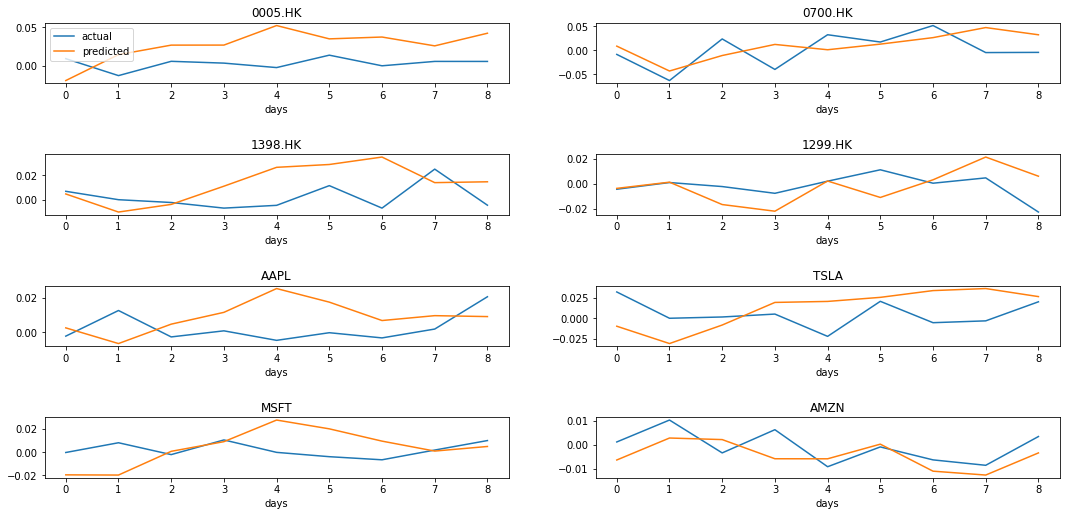

In [733]:
plot_pred_vs_actual(y_test_list_dl, y_pred_list_dl, symbols);

Unfortunately, as can be seen in the plots above, the performance of the Deep Learning algorithm was generally worse than that achieved by the XGBoost method.  Further tuning of the hyper-parameters, such as learning rate, neural network settings, is likely required to achieve more desirable results.  These are beyond the scope of this exercise.

## 5. Summary

In summary, we have explored the application of four popular machine learning methods in predicting stock price movements.

First, we address a simpler problem of classifying whether an unseen trading day would see a particular stock go up or down.  We used the relatively simple SVM and found that it performed well with consistently >50% accuracy in classifying a positive vs. a negative day.  Random Forrest, an ensemble method, was used to try to improve the results of SVM.  But we were not able to improve results with Random Forrest; neither did additional features in the training data.

Second, we move beyond simply classifying whether a day would be up or down, and onto the more complex problem price prediction.  We found that the XGBoost algorithm performed well on several stocks from the "old economy", such as HSBC (0005.HK), achieving very high price prediction accuracy.  This could be due to the predictability of such stocks' movement.  However, we were unable to achieve useful prediction for some other stocks such as Amazon (AMZN).  Finally we deploy Deep Learning algorithm with LSTM and CNN.  Unfortunately, we were unable to generate superior results than that achieved by the XGBoost method.  Further tuning of the hyper-parameters, such as learning rate, neural network settings, is likely required to achieve more desirable results. 

There are plenty of potential directions for future stuies and improvements.  First is in the field of alternative data sources - such as sentiment analysis of relevant news, social media statistics and even satellite monitoring.  These alternative data could serve as additional inputs to our pricing model.  Second is the fine tuning of models, such as those suggested in our discussion for Deep Learning models.